In [26]:
from google.colab import drive

drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive"
FOLDERNAME = "Datathon2026/data"
DATA_DIR = f"{BASE_DIR}/{FOLDERNAME}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import umap
import warnings
import geopandas as gpd
warnings.filterwarnings("ignore")


# Load Data

In [28]:
df = pd.read_csv(f"{DATA_DIR}/cleaned_data.csv")


# Feature Correlation

In [29]:
def plot_corr_heatmap(df, cols, title="Correlation heatmap"):
    X = df[cols].copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna(how="any")

    n = len(cols)
    corr = np.zeros((n, n))
    pval = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            r, p = pearsonr(X.iloc[:, i], X.iloc[:, j])
            corr[i, j] = r
            pval[i, j] = p

    plt.figure(figsize=(1.2 * n, 1.0 * n))
    plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
    plt.colorbar(label="correlation")

    plt.xticks(np.arange(n), cols, rotation=45, ha="right")
    plt.yticks(np.arange(n), cols)

    for i in range(n):
        for j in range(n):
            r = corr[i, j]
            p = pval[i, j]

            if p < 0.001:
                stars = "***"
            elif p < 0.01:
                stars = "**"
            elif p < 0.05:
                stars = "*"
            else:
                stars = ""

            text = f"{r:.2f}\n{stars}"
            plt.text(j, i, text, ha="center", va="center", color="black")

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [30]:
heatmap_cols_pollutant = [
    "pct_days_co",
    "pct_days_no2",
    "pct_days_ozone",
    "pct_days_pm2.5",
    "pct_days_pm10",
]


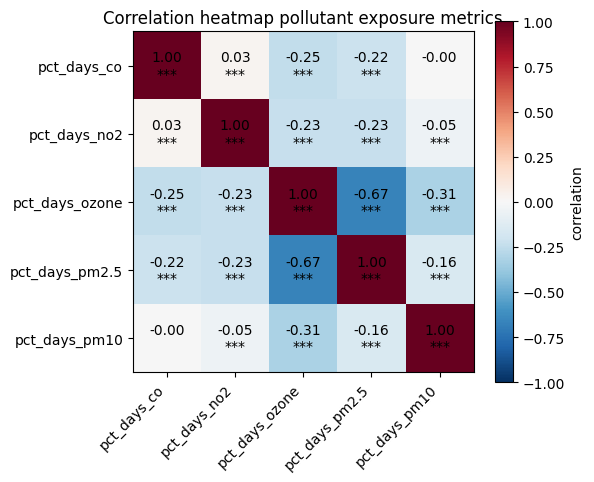

In [31]:
plot_corr_heatmap(
    df, heatmap_cols_pollutant, title="Correlation heatmap pollutant exposure metrics"
)

##  Pollutant Composition Relationships

### Ozone vs PM2.5
- Correlation ≈ -0.67

Interpretation:
- Counties dominated by ozone pollution tend not to be dominated by PM2.5, and vice versa.
- These pollutants reflect different physical processes:
  - Ozone: summer, sunlight-driven chemistry, often regional or suburban
  - PM2.5: combustion, winter conditions, industry, wildfire smoke

Implication for clustering:
- Both variables should be kept.
- Combining or dropping one would remove meaningful structure.

---

### CO / NO₂ vs Ozone and PM2.5
- Weak to moderate negative correlations (around -0.2)

Interpretation:
- Traffic-related pollution (CO, NO₂) behaves differently from regional or climate-driven pollution (ozone, PM).
- These represent separate pollution axes.

Implication for clustering:
- CO and NO₂ add urban and transportation signals that are not captured by ozone or PM.

---

### CO vs NO₂
- Correlation close to 0

Interpretation:
- Even though both are traffic-related, they capture different aspects of emissions and exposure.
- NO₂ is more local; CO has a broader background component.

Implication for clustering:
- Keeping both variables is reasonable.

In [32]:
heatmap_cols_core = [
    "pct_good_days",
    "pct_moderate_days",
    "pct_unhealthy_for_sensitive_groups_days",
    "pct_unhealthy_days",
    "pct_very_unhealthy_days",
    "pct_hazardous_days",
    "pct_unhealthy_plus",
    "Median AQI",
    "log_max_aqi",
    "max_to_median",
    "p90_to_median",
]


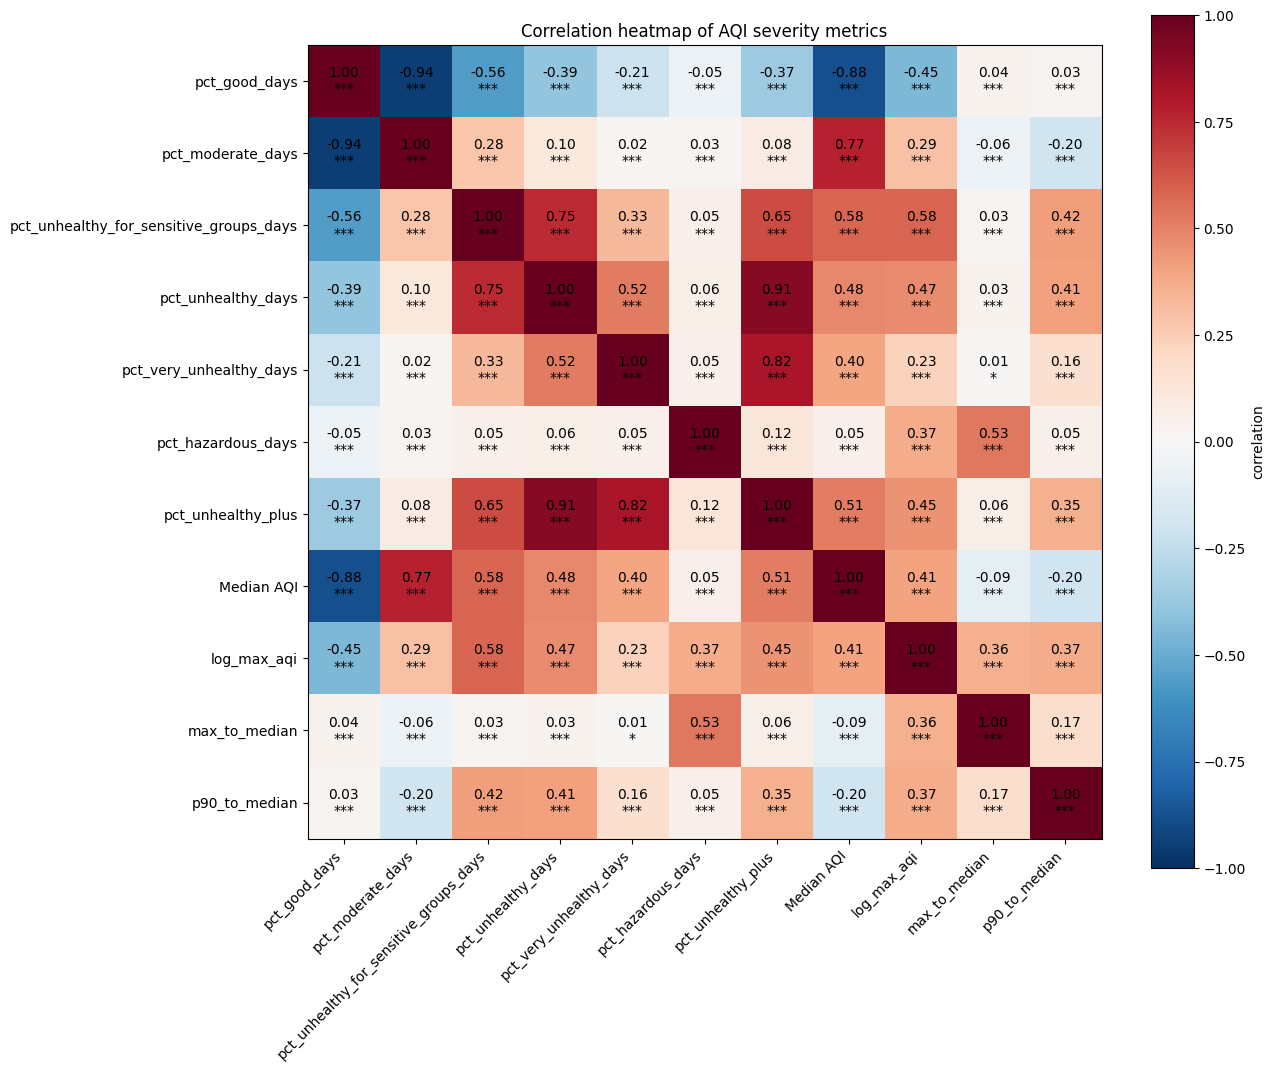

In [33]:
plot_corr_heatmap(
    df, heatmap_cols_core, title="Correlation heatmap of AQI severity metrics"
)


## AQI Structure and Severity Relationships

This section examines the correlation structure among AQI-related variables to guide feature selection for KMeans clustering. Because KMeans relies on distance metrics, highly correlated variables can distort cluster formation and should be reduced.

---

###  Good Days vs. Moderate Days

- Very strong negative correlation:
  - `pct_good_days` vs `pct_moderate_days` ≈ -0.94

**Interpretation:**
- Counties with a high share of good air quality days naturally have fewer moderate days.
- These two variables encode the same information in opposite directions.

**Implication for clustering:**
- Including both would introduce redundancy.
- Only one should be retained.
- We select `pct_good_days` for clearer interpretation as a baseline air quality indicator.

---

###  Unhealthy Category Percentages

- Strong positive correlations:
  - `pct_unhealthy_days` vs `pct_unhealthy_plus` ≈ 0.91
  - `pct_very_unhealthy_days` vs `pct_unhealthy_plus` ≈ 0.82

**Interpretation:**
- These variables lie on the same severity spectrum.
- They represent different thresholds of unhealthy air quality but reflect the same underlying pollution burden.

**Implication for clustering:**
- Using multiple unhealthy categories would overweight severity in distance calculations.
- We retain `pct_unhealthy_plus` as a comprehensive measure that captures all unhealthy and worse days.

---

###  Median AQI as Overall Exposure Indicator

- Strong relationships with multiple percentage-based variables:
  - Negative with `pct_good_days` (≈ -0.88)
  - Positive with `pct_moderate_days` (≈ 0.77)
  - Positive with `pct_unhealthy_plus` (≈ 0.51)

**Interpretation:**
- Median AQI summarizes typical daily air quality conditions.
- It reflects long-term exposure rather than rare extreme events.

**Implication for clustering:**
- Median AQI provides a stable baseline measure of pollution burden.
- It is retained as a core clustering feature.

---

###  Extreme Events: `log_max_aqi`

- Moderate correlation with Median AQI (≈ 0.41)

**Interpretation:**
- Some counties exhibit moderate typical air quality but experience occasional extreme pollution events (e.g., wildfire smoke).
- Typical conditions and extremes are related but not equivalent.

**Implication for clustering:**
- `log_max_aqi` introduces an extreme-risk dimension not captured by median-based metrics.
- Including it allows separation of chronic pollution from episodic spikes.

---

### Variability Metrics: Ratio-Based Features

- Ratio metrics:
  - `max_to_median`
  - `p90_to_median`
- Weak correlations with most percentage-based variables
- Moderate correlation with `log_max_aqi`

**Interpretation:**
- These ratios capture variability and anomaly rather than average conditions.
- High values indicate counties with rare but severe pollution spikes relative to their typical air quality.

**Implication for clustering:**
- Ratio features help distinguish counties with chronic exposure from those dominated by episodic extreme events.
- At least one ratio-based feature is useful for capturing pollution shape rather than level.


# K-means 

# Find the best K

In [34]:
cluster_features = [
    # exposure frequency
    "pct_good_days",
    "pct_unhealthy_plus",
    # intensity / spikes (log-compressed)
    "log_max_to_median",
    "log_max_aqi",
    "Median AQI",
    "p90_to_median",
    # pollutant dominance
    "pct_days_co",
    "pct_days_no2",
    "pct_days_ozone",
    "pct_days_pm2.5",
    "pct_days_pm10",
]

county_profile = df.groupby(["State", "County"]).mean().reset_index()

county_profile["log_max_to_median"] = np.log1p(county_profile["max_to_median"])

X = county_profile[cluster_features]

In [35]:
X = county_profile[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Elbow Graph

In [36]:
inertia = []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)


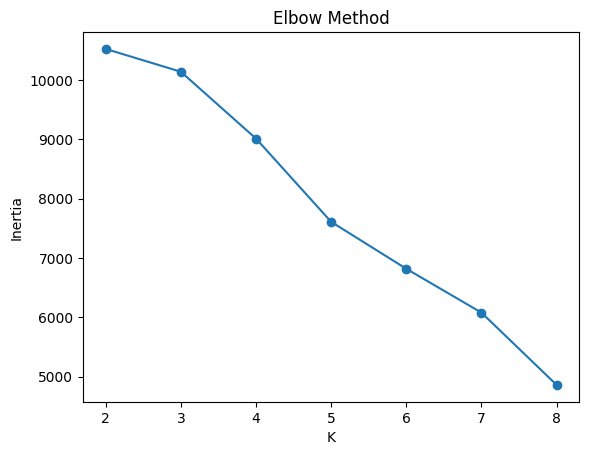

In [37]:
plt.plot(K_range, inertia, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


The elbow plot shows diminishing reductions in inertia beyond four clusters, indicating limited gains from adding more clusters. 

### Silhouette Score

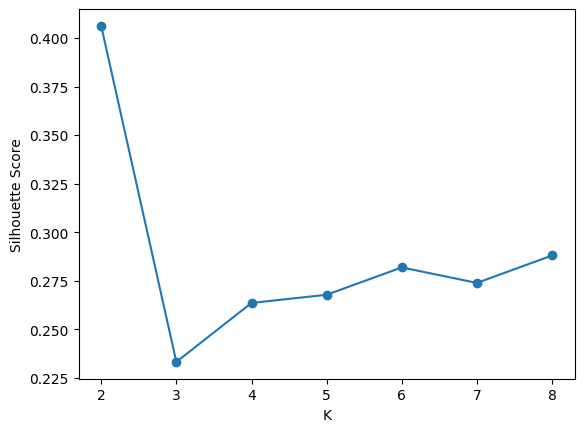

In [38]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 9), sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()


At the same time, the silhouette score start to decrease for K values greater than 4, suggesting that increasing the number of clusters does not improve much separation. 

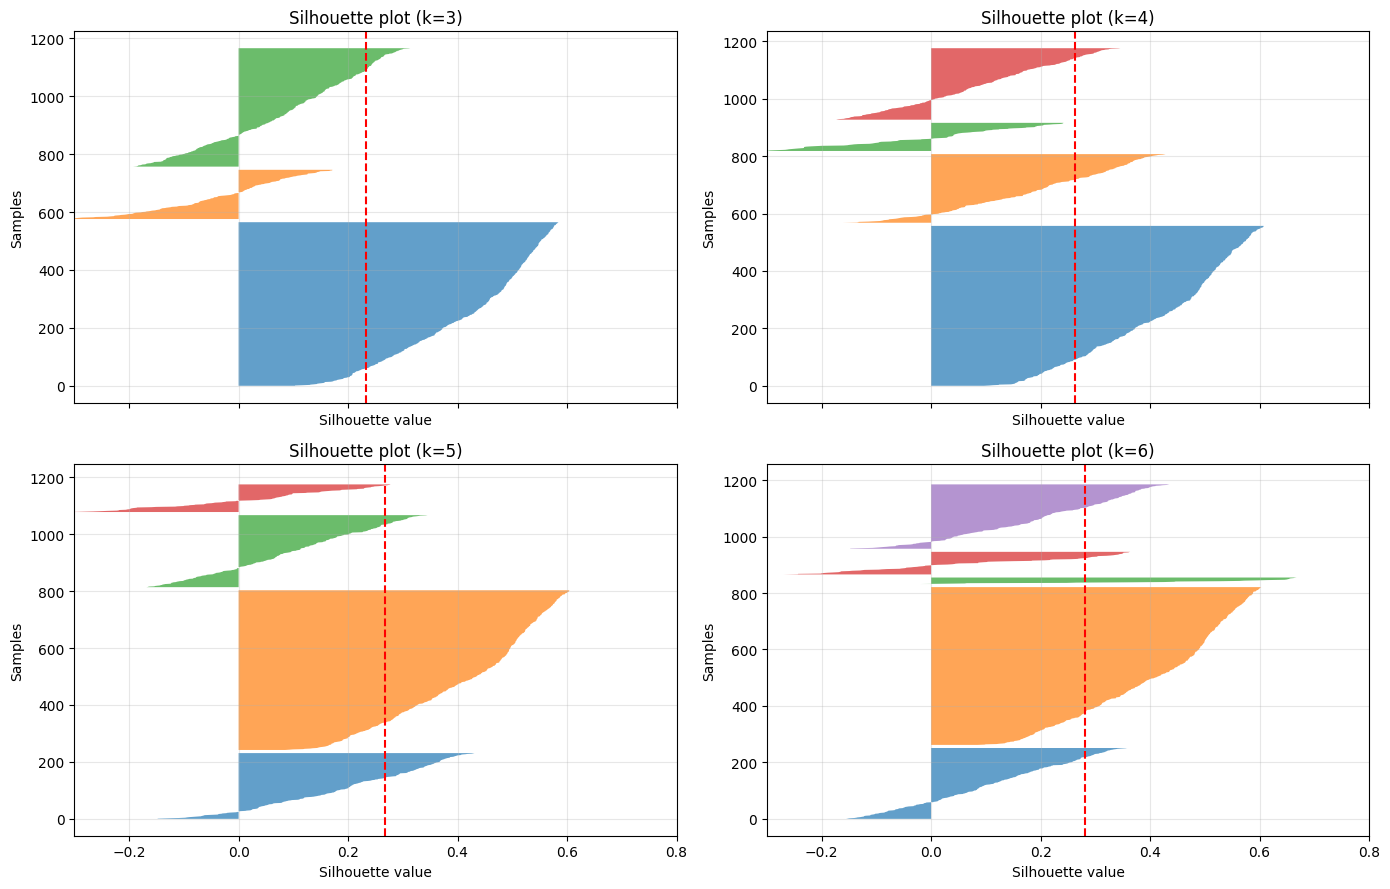

In [39]:
def silhouette_facet_kmeans(X_scaled, ks=(3, 4, 5, 6), random_state=42, n_init=10):
    ks = list(ks)
    n = len(ks)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols, figsize=(7 * ncols, 4.5 * nrows), sharex=True
    )
    axes = np.array(axes).reshape(-1)

    x_min, x_max = -0.3, 0.8

    for idx, k in enumerate(ks):
        ax = axes[idx]

        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = km.fit_predict(X_scaled)

        sil_vals = silhouette_samples(X_scaled, labels)
        sil_avg = sil_vals.mean()

        y_lower = 0
        for i in range(k):
            vals = sil_vals[labels == i]
            vals.sort()
            y_upper = y_lower + len(vals)

            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                vals,
                alpha=0.7,
            )
            y_lower = y_upper + 10

        ax.axvline(sil_avg, color="red", linestyle="--")
        ax.set_title(f"Silhouette plot (k={k})")
        ax.set_xlabel("Silhouette value")
        ax.set_ylabel("Samples")
        ax.set_xlim(x_min, x_max)
        ax.grid(True, alpha=0.3)

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

silhouette_facet_kmeans(X_scaled, ks=(3, 4, 5, 6))


We compared k = 3, 4, 5, and 6 using silhouette analysis.
- k = 3 under-clustered the data, collapsing multiple pollution profiles into a single dominant cluster.
- k = 5 and k = 6 slightly increased the average silhouette score but introduced several small, weakly separated clusters, indicating over-segmentation.
- k = 4 provided the best balance between separation, stability, and interpretability and was selected for downstream analysis.

## 4 Clusters Naming

In [40]:
km = KMeans(n_clusters=4, random_state=42, n_init=10)
county_profile["cluster"] = km.fit_predict(X_scaled)


In [41]:
county_profile.groupby("cluster")[cluster_features].mean()

,pct_good_days,pct_unhealthy_plus,log_max_to_median,log_max_aqi,Median AQI,p90_to_median,pct_days_co,pct_days_no2,pct_days_ozone,pct_days_pm2.5,pct_days_pm10
cluster,,,,,,,,,,,
0,0.776309,0.005115,1.473493,4.841901,39.528216,1.719295,0.013858,0.023448,0.830496,0.116220,0.015978
1,0.675808,0.002586,1.456917,4.749946,39.402994,1.682984,0.031515,0.022284,0.194476,0.717768,0.033957
2,0.906812,0.001207,1.813870,4.462918,21.401234,2.296310,0.143022,0.187844,0.085704,0.150663,0.432767
3,0.544359,0.025552,1.591798,5.166171,48.822327,1.943482,0.062053,0.109450,0.506966,0.287783,0.033749


In [ ]:
county_profile.to_csv(f"{DATA_DIR}/county_profile_with_clusters.csv", index=False)

# Cluster Interpretation and Naming

This section summarizes the air quality regimes identified by KMeans clustering.
Clusters are interpreted as profiles along an air quality gradient (typical burden, severity, and extremes),
with pollutant composition used mainly to describe dominant drivers.

---

## Cluster 0 — Ozone-Dominant Photochemical Pollution

**Profile summary**
- Ozone dominance (~83%)
- Median AQI ~39.5
- Moderate extremes (log_max_aqi ~4.84)
- Very low unhealthy-plus share (~0.5%)

**Interpretation**  
Counties in this cluster are primarily driven by ozone-related pollution. Typical air quality burden is moderate,
with relatively stable seasonal exposure patterns rather than persistent particulate dominance.

**Typical implication**  
Ozone-focused mitigation (precursors, seasonal controls) is likely most relevant.

---

## Cluster 1 — PM2.5-Dominant Chronic Pollution

**Profile summary**
- PM2.5 dominance (~72%)
- Median AQI ~39.4
- Similar extremes to Cluster 0 (log_max_aqi ~4.75)
- Low unhealthy-plus share (~0.26%)

**Interpretation**  
This cluster reflects counties where fine particulate matter (PM2.5) is the main driver of air quality burden.
Pollution is more consistent with sustained particulate exposure rather than large episodic spikes.

**Typical implication**  
Long-term health burden associated with sustained fine particulate exposure.

---

## Cluster 2 — Clean Baseline with Spiky/Composition-Shifted Events (Traffic/Dust)

**Profile summary**
- Lowest Median AQI (~21.4) and highest good-days share (~0.91)
- Highest variability (p90_to_median ~2.30; log_max_to_median ~1.81)
- Higher shares of CO (~0.14), NO2 (~0.19), and PM10 (~0.43)
- Low ozone (~0.09)

**Interpretation**  
These counties are generally clean most of the year but show strong variability and episodic spikes.
The composition suggests localized events (traffic-related or coarse dust) rather than sustained ozone or PM2.5 regimes.

**Typical implication**  
Short-lived or event-driven pollution; targeted local controls and event preparedness may matter more than chronic mitigation.

---

## Cluster 3 — High-Burden Mixed Pollution with Extremes

**Profile summary**
- Highest Median AQI (~48.8)
- Highest extreme intensity (log_max_aqi ~5.17)
- Highest unhealthy-plus share (~2.6%)
- Mixed drivers (ozone ~0.51, PM2.5 ~0.29) with notable NO2 (~0.11)

**Interpretation**  
This cluster captures counties with both elevated typical pollution and strong extreme events.
Multiple pollutant drivers suggest compounded exposure and higher long-term risk.

**Typical implication**  
Highest priority for health-risk mitigation and environmental justice focus due to compounded and persistent exposure.

---

## Cluster Labels for PCA / UMAP Visualizations

- **Cluster 0:** Ozone-Dominant  
- **Cluster 1:** PM2.5 Chronic  
- **Cluster 2:** Clean but Spiky (Traffic/Dust)  
- **Cluster 3:** High-Burden Mixed + Extremes


In [ ]:
cluster_labels = {
    0: "Ozone-Dominant",
    1: "PM2.5 Chronic",
    2: "Clean but Spiky (Traffic/Dust)",
    3: "High-Burden Mixed",
}


## Visual Validation

### PCA

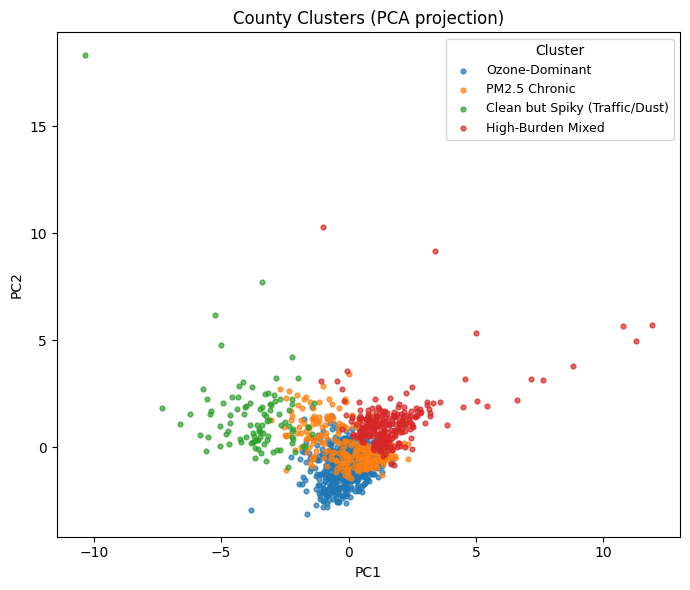

In [18]:


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))

for k, label in cluster_labels.items():
    mask = county_profile["cluster"] == k
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=12,
        alpha=0.7,
        label=label,
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("County Clusters (PCA projection)")
plt.legend(title="Cluster", fontsize=9)
plt.tight_layout()
plt.show()


### UMAP

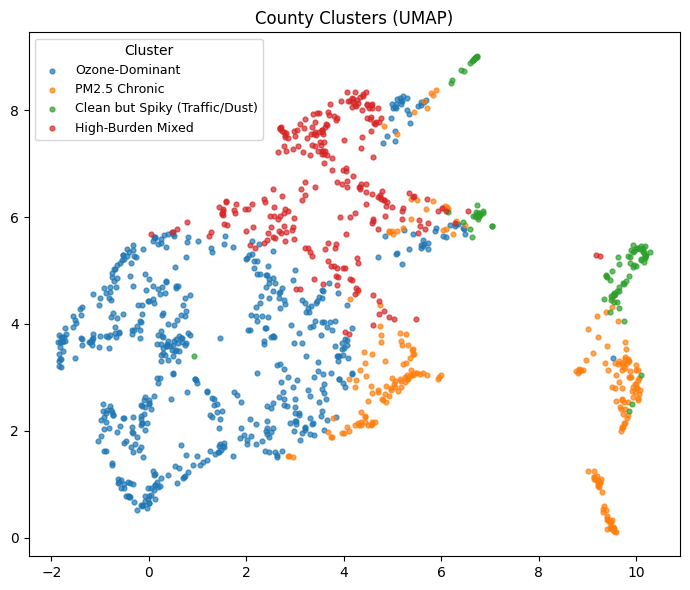

In [19]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))

for k, label in cluster_labels.items():
    mask = county_profile["cluster"] == k
    plt.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        s=12,
        alpha=0.7,
        label=label,
    )

plt.title("County Clusters (UMAP)")
plt.legend(title="Cluster", fontsize=9)
plt.tight_layout()
plt.show()


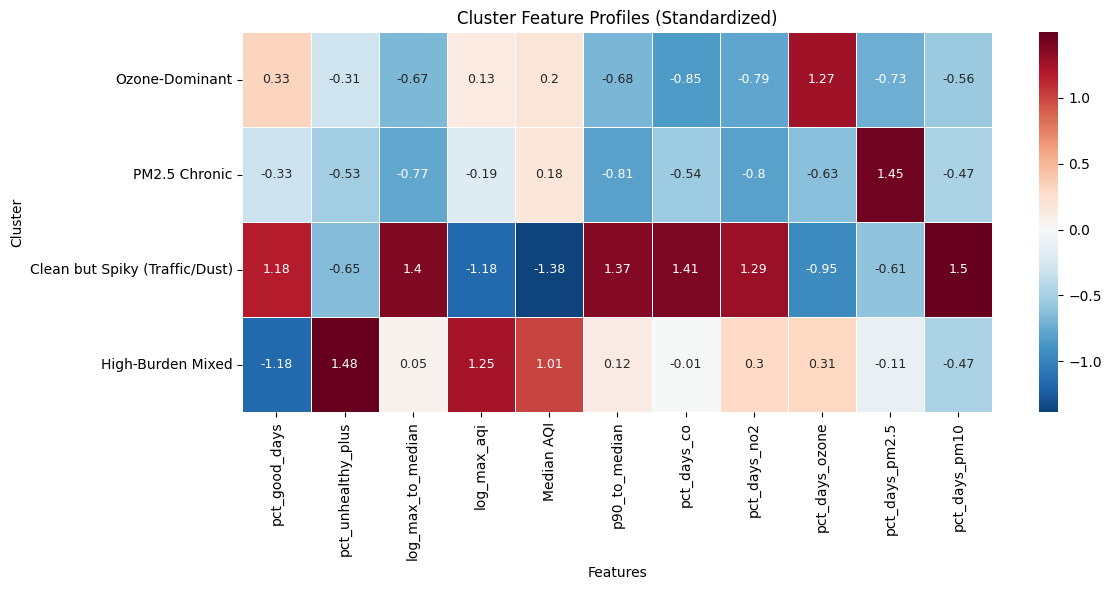

In [20]:
cluster_means = county_profile.groupby("cluster")[cluster_features].mean()

cluster_means_z = (cluster_means - cluster_means.mean()) / cluster_means.std()

pvals = pd.DataFrame(
    index=cluster_means.index, columns=cluster_means.columns, dtype=float
)

for c in cluster_means.index:
    for f in cluster_features:
        x1 = county_profile.loc[county_profile["cluster"] == c, f]
        x2 = county_profile.loc[county_profile["cluster"] != c, f]

        _, p = ttest_ind(x1, x2, equal_var=False, nan_policy="omit")
        pvals.loc[c, f] = p

annot = cluster_means_z.round(2).astype(str)

cluster_means_z.index = [cluster_labels[c] for c in cluster_means_z.index]
annot.index = cluster_means_z.index

plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_means_z,
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    annot=annot,
    fmt="",
    annot_kws={"fontsize": 9},
)

plt.title("Cluster Feature Profiles (Standardized)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


In [21]:
county_profile["cluster_name"] = county_profile["cluster"].map(cluster_labels)
df = df.merge(
    county_profile[["State", "County", "cluster", "cluster_name"]],
    on=["State", "County"],
    how="left",
)


In [ ]:
df.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'log_max_aqi', 'pct_good_days',
       'pct_moderate_days', 'pct_unhealthy_for_sensitive_groups_days',
       'pct_unhealthy_days', 'pct_very_unhealthy_days', 'pct_hazardous_days',
       'pct_unhealthy_plus', 'max_to_median', 'p90_to_median', 'pct_days_co',
       'pct_days_no2', 'pct_days_ozone', 'pct_days_pm2.5', 'pct_days_pm10',
       'cluster', 'cluster_name'],
      dtype='object')

In [ ]:
STATE_ABBR = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}
county_profile["state_abbr"] = county_profile["State"].map(STATE_ABBR)

In [24]:
from matplotlib.colors import ListedColormap

cluster_order = [
    "Clean but Spiky (Traffic/Dust)",
    "Ozone-Dominant",
    "PM2.5 Chronic",
    "High-Burden Mixed",
]

cluster_colors = [
    "#2ca02c",
    "#ffdd57",
    "#ff7f0e",
    "#d62728",
]

cmap = ListedColormap(cluster_colors)


missing cluster rate: 0.6438223938223938


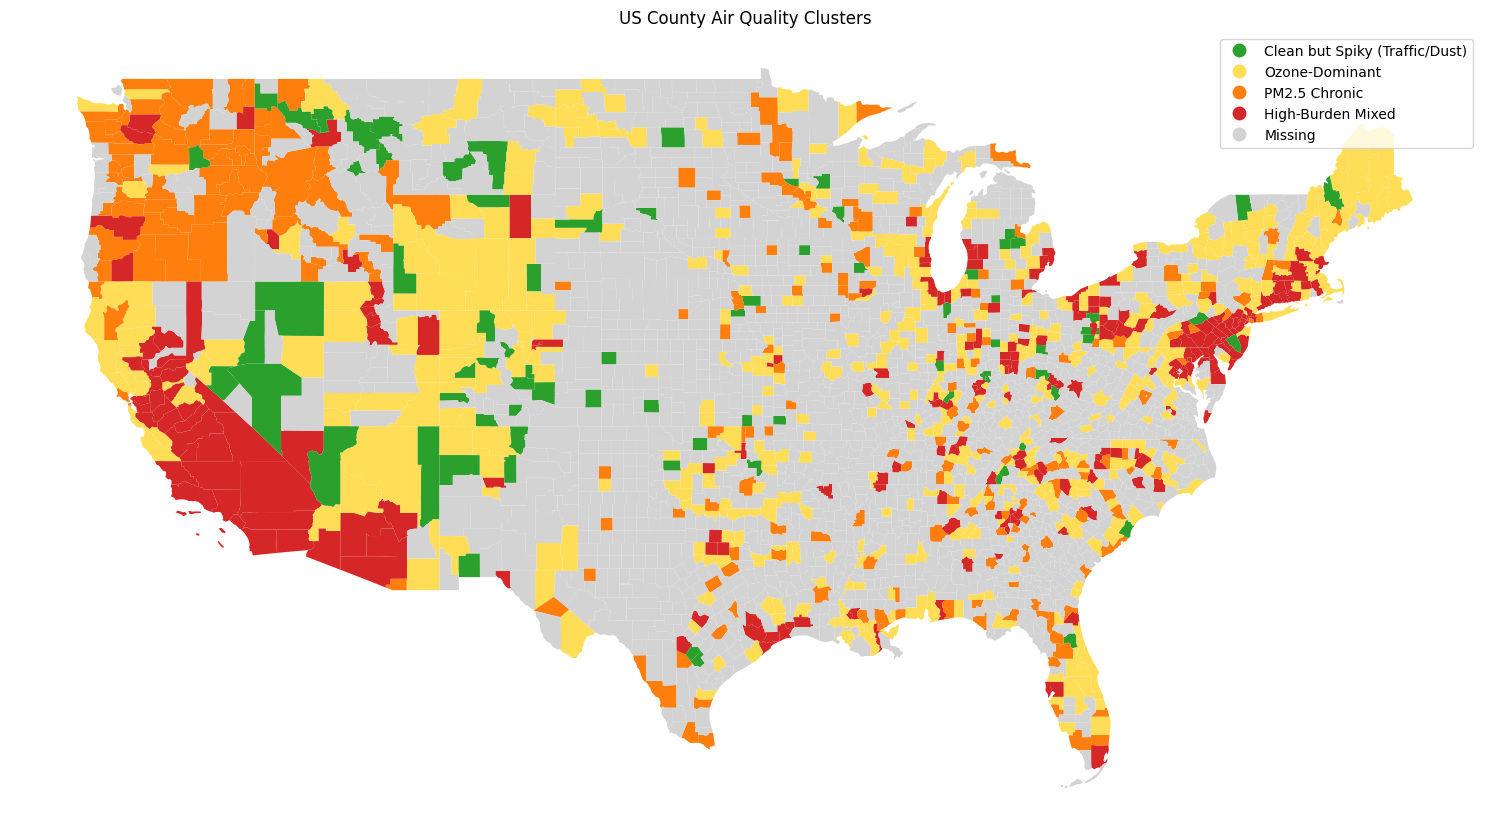

In [25]:
counties = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip"
)

map_df = counties.merge(
    county_profile[["County", "state_abbr", "cluster", "cluster_name"]],
    left_on=["NAME", "STUSPS"],
    right_on=["County", "state_abbr"],
    how="left",
)

map_df["cluster_name"] = pd.Categorical(
    map_df["cluster_name"], categories=cluster_order, ordered=True
)

map_df = map_df[~map_df["STUSPS"].isin(["AK", "HI", "PR"])]

print("missing cluster rate:", map_df["cluster"].isna().mean())

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
map_df.plot(
    column="cluster_name",
    categorical=True,
    cmap=cmap,
    legend=True,
    linewidth=0,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "Missing"},
)
ax.set_title("US County Air Quality Clusters")
ax.axis("off")
plt.tight_layout()
plt.show()


*Gray counties indicate areas without sufficient AQI monitoring data and are excluded from clustering.*

## Spatial Interpretation of County-Level Air Quality Clusters

### 1. Western United States

**High-Burden Mixed (red)**  
This cluster is mainly located in central and southern California, inland valleys, and parts of the Southwest. These areas are closely linked to wildfires, high summer ozone, and terrain that limits air circulation. Counties in this group show both high baseline pollution and frequent extreme events, indicating long-term exposure together with short, intense spikes.

**Ozone-Dominant (Yellow)**  
Counties in this group are spread across the western interior, high-elevation regions, and much of the southern United States. Pollution is largely driven by summer ozone formation, while particulate matter levels remain relatively low. This spatial pattern matches the ozone-focused profile seen in the cluster features.

**PM2.5 Chronic (Orange)**  
This cluster is concentrated in the Pacific Northwest, mountainous regions, and areas linked to agriculture or forestry. These counties tend to experience persistent PM2.5 exposure, often related to combustion sources, winter inversions, and background regional pollution.

---

### 2. Central United States: Missing Counties

Large areas in the central United States appear as missing (gray). This reflects data availability rather than model behavior. Many counties lack consistent AQI monitoring, and EPA coverage is uneven at the county level. As a result, these counties are excluded from clustering.

---

### 3. Eastern United States and the Great Lakes

**High-Burden Mixed (red)**  
This cluster appears along the Northeast corridor and around the Great Lakes. These regions combine dense population, long industrial history, and heavy transportation activity, leading to consistently higher pollution levels and more frequent extremes.

**Clean but Spiky (green)**  
Counties in this cluster appear scattered near metropolitan areas and across parts of the Midwest. They generally have low typical pollution levels but show occasional sharp spikes, likely tied to traffic, short-term weather events, or local sources.
